In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil
from pathlib import Path
import csv
import pathlib
from typing import Any, Callable, Optional, Tuple

import torch
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import verify_str_arg, check_integrity
from PIL import Image

# CV Classification

In [2]:
data_path = Path("../data/ck_data")
all_count = len(list((data_path / "train").rglob("*.png")))
weights = []
for e in list((data_path / "train").iterdir()):
    weights.append([e.name, len(list(e.iterdir()))])

def f(w):
    new_w = list(w)
    new_w[1] = round(1 - w[1] / all_count, 4)
    return new_w

weights = list(map(lambda x: f(x), weights))
sorted(weights)

[['angry', 0.9658],
 ['disgust', 0.9553],
 ['fear', 0.981],
 ['happy', 0.9477],
 ['neutral', 0.2342],
 ['sad', 0.9788],
 ['surprise', 0.9369]]

In [8]:
data_path = Path("../data/emotions_cv")
class_count = []
for e in list((data_path / "train").iterdir()):
    if e.name == "contempt":
        continue
    class_count.append(len(list(e.iterdir())))

['fear', 'neutral', 'angry', 'happy', 'disgust', 'sad', 'surprise'] [3326, 3979, 3353, 5909, 502, 3908, 2730]


<BarContainer object of 7 artists>

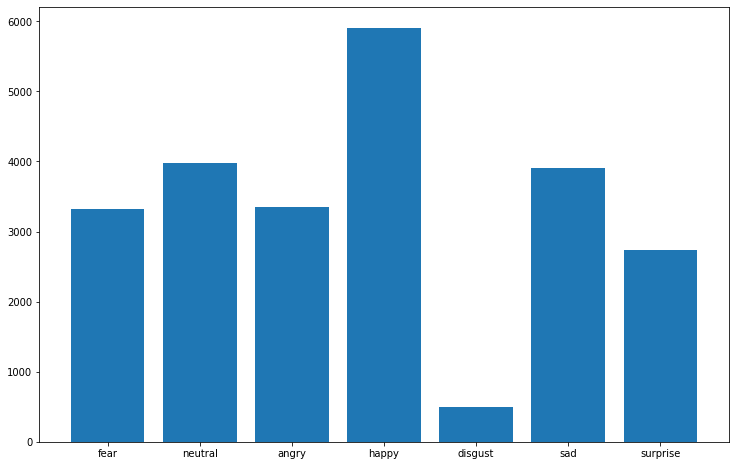

In [9]:
import matplotlib.pyplot as plt
names = [p.name for p in (data_path / "train").iterdir() if p.name != "contempt"]
plt.figure(figsize=(42, 8))
plt.subplot(131)
print(names, class_count)
plt.bar(names, class_count)

In [12]:
df = pd.read_csv("../data/fer2013/full.csv")

In [13]:
df.head(1)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...


In [14]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
val.shape, train.shape

((5742, 2), (22967, 2))

In [16]:
val.to_csv("../data/fer2013/val.csv", index=False)
train.to_csv("../data/fer2013/train.csv", index=False)

In [17]:
class FER2013(VisionDataset):
    """`FER2013
    <https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``root/fer2013`` exists.
        split (string, optional): The dataset split, supports ``"train"`` (default), or ``"test"``.
        transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed
            version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the target and transforms it.
    """

    _RESOURCES = {
        "train": ("train.csv", None),
        "test": ("test.csv", None),
        "val": ("val.csv", None),
    }

    def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        self._split = verify_str_arg(split, "split", self._RESOURCES.keys())
        super().__init__(root, transform=transform, target_transform=target_transform)

        base_folder = pathlib.Path(self.root) / "fer2013"
        file_name, md5 = self._RESOURCES[self._split]
        data_file = base_folder / file_name
        if not check_integrity(str(data_file), md5=md5):
            raise RuntimeError(
                f"{file_name} not found in {base_folder} or corrupted. "
                f"You can download it from "
                f"https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge"
            )

        with open(data_file, "r", newline="") as file:
            self._samples = [
                (
                    torch.tensor(
                        [int(idx) for idx in row["pixels"].split()], dtype=torch.uint8
                    ).reshape(48, 48),
                    int(row["emotion"]) if "emotion" in row else None,
                )
                for row in csv.DictReader(file)
            ]

    def __len__(self) -> int:
        return len(self._samples)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        image_tensor, target = self._samples[idx]
        image = Image.fromarray(image_tensor.numpy())

        if self.transform is not None:
            image = self.transform(image)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target

    def extra_repr(self) -> str:
        return f"split={self._split}"


In [18]:
train_dataset = FER2013("../data", "train")
valid_dataset = FER2013("../data", "val")

In [19]:
train_dir = "../data/fer2013/train"
val_dir = "../data/fer2013/val"
emo_map = {
    0: "angry",
    1: "disgust", 
    2: "fear", 
    3: "happy", 
    4: "sad",
    5: "surprise", 
    6: "neutral"
}

In [30]:
for i, (image, target) in enumerate(tqdm(train_dataset)):
    folder = emo_map[target]
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    image.save(os.path.join(train_dir, folder, str(i) + ".png"))

100%|██████████| 22967/22967 [00:04<00:00, 4834.99it/s]


In [31]:
for i, (image, target) in enumerate(tqdm(valid_dataset)):
    folder = emo_map[target]
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)
    image.save(os.path.join(val_dir, folder, str(i) + ".png"))

100%|██████████| 5742/5742 [00:01<00:00, 4842.43it/s]


In [33]:
from pathlib import Path
ck_p = Path("../data/CK+48")
fer_p = Path("../data/fer2013/")
ck2fer = {
    "anger": "angry",
    "contempt": "contempt",
    "disgust": "disgust",
    "fear": "fear",
    "happy": "happy",
    "sadness": "sad",
    "surprise": "surprise"
}
for e in tqdm(list(ck_p.iterdir())):
    images_paths = list(e.iterdir())
    train_imgs, val_imgs = train_test_split(images_paths, test_size=0.2, random_state=42)
    (fer_p / "train" / ck2fer[e.name]).mkdir(exist_ok=True)
    (fer_p / "val" / ck2fer[e.name]).mkdir(exist_ok=True)
    for ti in train_imgs:
        ti.rename(fer_p / "train" / ck2fer[e.name] / ti.name)
    for vi in val_imgs:
        vi.rename(fer_p / "val" / ck2fer[e.name] / vi.name)

100%|██████████| 7/7 [00:00<00:00, 225.99it/s]


In [37]:
weights = []
for e in list((fer_p / "train").iterdir()):
    weights.append([e.name, len(list(e.iterdir()))])

def f(w):
    new_w = list(w)
    new_w[1] = round(1 - w[1] / len(df), 4)
    return new_w

weights = list(map(lambda x: f(x), weights))
sorted(weights)

[['angry', 0.8832],
 ['contempt', 0.9985],
 ['disgust', 0.9825],
 ['fear', 0.8841],
 ['happy', 0.7942],
 ['neutral', 0.8614],
 ['sad', 0.8639],
 ['surprise', 0.9049]]

In [38]:
from pathlib import Path
ck_p = Path("../data/CK+48")
final_p = Path("../data/ck_data")

for e in ck_p.iterdir():
    images_paths = list(e.iterdir())
    train_imgs, val_imgs = train_test_split(images_paths, test_size=0.2, random_state=42)
    (final_p / "train" / e.name).mkdir(exist_ok=True)
    (final_p / "val" / e.name).mkdir(exist_ok=True)
    for ti in train_imgs:
        ti.rename(final_p / "train" / e.name / ti.name)
    for vi in val_imgs:
        vi.rename(final_p / "val" / e.name / vi.name)    

# Audio Classification

Install 
- https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
- https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
- https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess

**RAVDESS**
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion **(01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)**.
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).



**SAVEE**
- four native English male speakers (identified as DC, JE, JK, KL),
- Emotion has been described psychologically in discrete categories: **anger, disgust, fear, happiness, sadness, surprise, neutral**. 

**TESS**
- There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions **(anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral)**. There are 2800 data points (audio files) in total.

In [3]:
FINAL_DIR = Path("../data/emotions_audio/")
RAVDESS_DIR = Path("../data/emotions_audio_todo/RAVDESS")
SAVEE_DIR = Path("../data/emotions_audio_todo/SAVEE")
TESS_DIR = Path("../data/emotions_audio_todo/TESS")

ravdes_map = {
    "01": "neutral",
    "02": "neutral",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fear",
    "07": "disgust",
    "08": "surprise"
}
savee_map = {
    "a": "angry",
    "d": "disgust",
    "f": "fear",
    "h": "happy",
    "n": "neutral",
    "sa": "sad",
    "su": "surprise",
}

In [4]:
def prepare_ravdess():
    wavs = list(RAVDESS_DIR.rglob("*.wav"))
    train_wavs, val_wavs = train_test_split(wavs, test_size=0.2, random_state=42)
    for stage, wavs in zip(["train", "val"], [train_wavs, val_wavs]):
        for wav in tqdm(wavs):
            code = wav.name.split("-")[2]
            e = ravdes_map[code]
            (FINAL_DIR / stage / e).mkdir(exist_ok=True)
            shutil.copy(wav, FINAL_DIR / stage / e / wav.name)
prepare_ravdess()

100%|██████████| 288/288 [00:00<00:00, 1339.64it/s]


In [11]:
def prepare_savee():
    wavs = list(SAVEE_DIR.rglob("*.wav"))
    train_wavs, val_wavs = train_test_split(wavs, test_size=0.2, random_state=42)
    for stage, wavs in zip(["train", "val"], [train_wavs, val_wavs]):
        for wav in tqdm(wavs):
            code = wav.name[3]
            if code == "s":
                code += wav.name[4]
            e = savee_map[code]
            (FINAL_DIR / stage / e).mkdir(exist_ok=True)        
            shutil.copy(wav, FINAL_DIR / stage / e / wav.name)
prepare_savee()

100%|██████████| 96/96 [00:00<00:00, 3576.91it/s]


In [12]:
def prepare_tess():
    wavs = list(TESS_DIR.rglob("*.wav"))
    train_wavs, val_wavs = train_test_split(wavs, test_size=0.2, random_state=42)
    for stage, wavs in zip(["train", "val"], [train_wavs, val_wavs]):
        for wav in tqdm(wavs):
            e = wav.parts[-2].split("_")[-1]
            (FINAL_DIR / stage / e).mkdir(exist_ok=True)        
            shutil.copy(wav, FINAL_DIR / stage / e / wav.name)
prepare_tess()

100%|██████████| 560/560 [00:00<00:00, 6057.54it/s]


['fear', 'neutral', 'angry', 'happy', 'disgust', 'sad', 'surprise'] [153, 226, 153, 156, 158, 153, 152]


<BarContainer object of 7 artists>

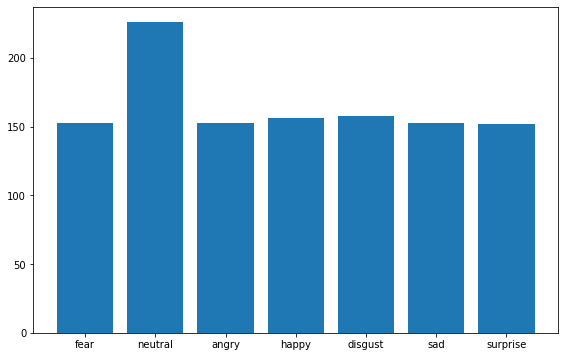

In [21]:
import matplotlib.pyplot as plt

data_path = Path("../data/emotions_audio_full")
class_count = []
for e in list((data_path / "train").iterdir()):
    class_count.append(len(list(e.iterdir())))
plt.figure(figsize=(32, 6))
plt.subplot(131)
print(names, class_count)
plt.bar(names, class_count)